In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from einops import rearrange
from einops.layers.torch import Rearrange
from timm.models.layers import trunc_normal_, DropPath
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
from torchvision.transforms.functional import to_tensor, to_pil_image

/home/g202319350/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Models

In [2]:
class WMSA(nn.Module):
    """ Self-attention module in Swin Transformer
    """

    def __init__(self, input_dim, output_dim, head_dim, window_size, type):
        super(WMSA, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.head_dim = head_dim
        self.scale = self.head_dim ** -0.5
        self.n_heads = input_dim//head_dim
        self.window_size = window_size
        self.type=type
        self.embedding_layer = nn.Linear(self.input_dim, 3*self.input_dim, bias=True)

        # TODO recover
        # self.relative_position_params = nn.Parameter(torch.zeros(self.n_heads, 2 * window_size - 1, 2 * window_size -1))
        self.relative_position_params = nn.Parameter(torch.zeros((2 * window_size - 1)*(2 * window_size -1), self.n_heads))

        self.linear = nn.Linear(self.input_dim, self.output_dim)

        trunc_normal_(self.relative_position_params, std=.02)
        self.relative_position_params = torch.nn.Parameter(self.relative_position_params.view(2*window_size-1, 2*window_size-1, self.n_heads).transpose(1,2).transpose(0,1))

    def generate_mask(self, h, w, p, shift):
        """ generating the mask of SW-MSA
        Args:
            shift: shift parameters in CyclicShift.
        Returns:
            attn_mask: should be (1 1 w p p),
        """
        # supporting sqaure.
        attn_mask = torch.zeros(h, w, p, p, p, p, dtype=torch.bool, device=self.relative_position_params.device)
        if self.type == 'W':
            return attn_mask

        s = p - shift
        attn_mask[-1, :, :s, :, s:, :] = True
        attn_mask[-1, :, s:, :, :s, :] = True
        attn_mask[:, -1, :, :s, :, s:] = True
        attn_mask[:, -1, :, s:, :, :s] = True
        attn_mask = rearrange(attn_mask, 'w1 w2 p1 p2 p3 p4 -> 1 1 (w1 w2) (p1 p2) (p3 p4)')
        return attn_mask

    def forward(self, x):
        """ Forward pass of Window Multi-head Self-attention module.
        Args:
            x: input tensor with shape of [b h w c];
            attn_mask: attention mask, fill -inf where the value is True;
        Returns:
            output: tensor shape [b h w c]
        """
        if self.type!='W': x = torch.roll(x, shifts=(-(self.window_size//2), -(self.window_size//2)), dims=(1,2))
        x = rearrange(x, 'b (w1 p1) (w2 p2) c -> b w1 w2 p1 p2 c', p1=self.window_size, p2=self.window_size)
        h_windows = x.size(1)
        w_windows = x.size(2)
        # sqaure validation
        # assert h_windows == w_windows

        x = rearrange(x, 'b w1 w2 p1 p2 c -> b (w1 w2) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        qkv = self.embedding_layer(x)
        q, k, v = rearrange(qkv, 'b nw np (threeh c) -> threeh b nw np c', c=self.head_dim).chunk(3, dim=0)
        sim = torch.einsum('hbwpc,hbwqc->hbwpq', q, k) * self.scale
        # Adding learnable relative embedding
        sim = sim + rearrange(self.relative_embedding(), 'h p q -> h 1 1 p q')
        # Using Attn Mask to distinguish different subwindows.
        if self.type != 'W':
            attn_mask = self.generate_mask(h_windows, w_windows, self.window_size, shift=self.window_size//2)
            sim = sim.masked_fill_(attn_mask, float("-inf"))

        probs = nn.functional.softmax(sim, dim=-1)
        output = torch.einsum('hbwij,hbwjc->hbwic', probs, v)
        output = rearrange(output, 'h b w p c -> b w p (h c)')
        output = self.linear(output)
        output = rearrange(output, 'b (w1 w2) (p1 p2) c -> b (w1 p1) (w2 p2) c', w1=h_windows, p1=self.window_size)

        if self.type!='W': output = torch.roll(output, shifts=(self.window_size//2, self.window_size//2), dims=(1,2))
        return output

    def relative_embedding(self):
        cord = torch.tensor(np.array([[i, j] for i in range(self.window_size) for j in range(self.window_size)]))
        relation = cord[:, None, :] - cord[None, :, :] + self.window_size -1
        # negative is allowed
        return self.relative_position_params[:, relation[:,:,0].long(), relation[:,:,1].long()]


class Block(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer Block
        """
        super(Block, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        assert type in ['W', 'SW']
        self.type = type
        if input_resolution <= window_size:
            self.type = 'W'

        print("Block Initial Type: {}, drop_path_rate:{:.6f}".format(self.type, drop_path))
        self.ln1 = nn.LayerNorm(input_dim)
        self.msa = WMSA(input_dim, input_dim, head_dim, window_size, self.type)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.ln2 = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 4 * input_dim),
            nn.GELU(),
            nn.Linear(4 * input_dim, output_dim),
        )

    def forward(self, x):
        x = x + self.drop_path(self.msa(self.ln1(x)))
        x = x + self.drop_path(self.mlp(self.ln2(x)))
        return x

class MiniBlock(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer Block
        """
        super(MiniBlock, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        assert type in ['W', 'SW']
        self.type = type
        if input_resolution <= window_size:
            self.type = 'W'

        print("Block Initial Type: {}, drop_path_rate:{:.6f}".format(self.type, drop_path))
        self.ln1 = nn.LayerNorm(input_dim)
        self.msa = WMSA(input_dim, input_dim, head_dim, window_size, self.type)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.ln2 = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 1 * input_dim),
            nn.GELU(),
            nn.Linear(1 * input_dim, output_dim),
        )

    def forward(self, x):
        x = x + self.drop_path(self.msa(self.ln1(x)))
        x = x + self.drop_path(self.mlp(self.ln2(x)))
        return x

class ConvTransBlock(nn.Module):
    def __init__(self, conv_dim, trans_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer and Conv Block
        """
        super(ConvTransBlock, self).__init__()
        self.conv_dim = conv_dim
        self.trans_dim = trans_dim
        self.head_dim = head_dim
        self.window_size = window_size
        self.drop_path = drop_path
        self.type = type
        self.input_resolution = input_resolution

        assert self.type in ['W', 'SW']
        if self.input_resolution <= self.window_size:
            self.type = 'W'

        self.trans_block = Block(self.trans_dim, self.trans_dim, self.head_dim, self.window_size, self.drop_path, self.type, self.input_resolution)
        self.conv1_1 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)
        self.conv1_2 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)

        self.conv_block = nn.Sequential(
                nn.Conv2d(self.conv_dim, self.conv_dim, 3, 1, 1, bias=False),
                nn.ReLU(True),
                nn.Conv2d(self.conv_dim, self.conv_dim, 3, 1, 1, bias=False)
                )

    def forward(self, x):
        conv_x, trans_x = torch.split(self.conv1_1(x), (self.conv_dim, self.trans_dim), dim=1)
        conv_x = self.conv_block(conv_x) + conv_x
        trans_x = Rearrange('b c h w -> b h w c')(trans_x)
        trans_x = self.trans_block(trans_x)
        trans_x = Rearrange('b h w c -> b c h w')(trans_x)
        res = self.conv1_2(torch.cat((conv_x, trans_x), dim=1))
        x = x + res

        return x

class MiniConvTransBlock(nn.Module):
    def __init__(self, conv_dim, trans_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer and Conv Block
        """
        super(MiniConvTransBlock, self).__init__()
        self.conv_dim = conv_dim
        self.trans_dim = trans_dim
        self.head_dim = head_dim
        self.window_size = window_size
        self.drop_path = drop_path
        self.type = type
        self.input_resolution = input_resolution

        assert self.type in ['W', 'SW']
        if self.input_resolution <= self.window_size:
            self.type = 'W'

        self.trans_block = MiniBlock(self.trans_dim, self.trans_dim, self.head_dim, self.window_size, self.drop_path, self.type, self.input_resolution)
        self.conv1_1 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)
        self.conv1_2 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)

        self.conv_block = nn.Sequential(
                nn.Conv2d(self.conv_dim, self.conv_dim, 3, 1, 1, bias=False),
                nn.ReLU(True),
                nn.Conv2d(self.conv_dim, self.conv_dim, 3, 1, 1, bias=False)
                )

    def forward(self, x):
        conv_x, trans_x = torch.split(self.conv1_1(x), (self.conv_dim, self.trans_dim), dim=1)
        conv_x = self.conv_block(conv_x) + conv_x
        trans_x = Rearrange('b c h w -> b h w c')(trans_x)
        trans_x = self.trans_block(trans_x)
        trans_x = Rearrange('b h w c -> b c h w')(trans_x)
        res = self.conv1_2(torch.cat((conv_x, trans_x), dim=1))
        x = x + res

        return x


# Squeeze-and-Excitation Block
class SqueezeExciteBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SqueezeExciteBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Squeeze operation
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)  # Bottleneck
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)  # Expand
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.shape
        se = self.global_avg_pool(x).view(batch_size, channels)
        se = self.relu(self.fc1(se))
        se = self.sigmoid(self.fc2(se))
        se = se.view(batch_size, channels, 1, 1)  # Reshape for broadcasting
        return x * se  # Channel-wise scaling


class SCUNet(nn.Module):

    def __init__(self, in_nc=1, config=[2,2,2,2,2,2,2], dim=64, drop_path_rate=0.0, input_resolution=256):
        super(SCUNet, self).__init__()
        self.config = config
        self.dim = dim
        self.head_dim = 32
        self.window_size = 8

        # drop path rate for each layer
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(config))]

        self.m_head = [nn.Conv2d(in_nc, dim, 3, 1, 1, bias=False)]

        begin = 0
        self.m_down1 = [ConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution)
                      for i in range(config[0])] + \
                      [nn.Conv2d(dim, 2*dim, 2, 2, 0, bias=False)]

        begin += config[0]
        self.m_down2 = [ConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
                      for i in range(config[1])] + \
                      [nn.Conv2d(2*dim, 4*dim, 2, 2, 0, bias=False)]

        begin += config[1]
        self.m_down3 = [ConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW',input_resolution//4)
                      for i in range(config[2])] + \
                      [nn.Conv2d(4*dim, 8*dim, 2, 2, 0, bias=False)]

        begin += config[2]
        self.m_body = [ConvTransBlock(4*dim, 4*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//8)
                    for i in range(config[3])]

        begin += config[3]
        self.m_up3 = [nn.ConvTranspose2d(8*dim, 4*dim, 2, 2, 0, bias=False),] + \
                      [ConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW',input_resolution//4)
                      for i in range(config[4])]

        begin += config[4]
        self.m_up2 = [nn.ConvTranspose2d(4*dim, 2*dim, 2, 2, 0, bias=False),] + \
                      [ConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
                      for i in range(config[5])]

        begin += config[5]
        self.m_up1 = [nn.ConvTranspose2d(2*dim, dim, 2, 2, 0, bias=False),] + \
                    [ConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution)
                      for i in range(config[6])]

        self.m_tail = [nn.Conv2d(dim, in_nc, 3, 1, 1, bias=False)]

        self.m_head = nn.Sequential(*self.m_head)
        self.m_down1 = nn.Sequential(*self.m_down1)
        self.m_down2 = nn.Sequential(*self.m_down2)
        self.m_down3 = nn.Sequential(*self.m_down3)
        self.m_body = nn.Sequential(*self.m_body)
        self.m_up3 = nn.Sequential(*self.m_up3)
        self.m_up2 = nn.Sequential(*self.m_up2)
        self.m_up1 = nn.Sequential(*self.m_up1)
        self.m_tail = nn.Sequential(*self.m_tail)
        #self.apply(self._init_weights)

    def forward(self, x0):

        h, w = x0.size()[-2:]
        paddingBottom = int(np.ceil(h/64)*64-h)
        paddingRight = int(np.ceil(w/64)*64-w)
        x0 = nn.ReplicationPad2d((0, paddingRight, 0, paddingBottom))(x0)

        x1 = self.m_head(x0)
        x2 = self.m_down1(x1)
        x3 = self.m_down2(x2)
        x4 = self.m_down3(x3)
        x = self.m_body(x4)
        x = self.m_up3(x+x4)
        x = self.m_up2(x+x3)
        x = self.m_up1(x+x2)
        x = self.m_tail(x+x1)

        x = x[..., :h, :w]

        return x


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


# Modified SCUNet with SE Blocks
class SE_SCUNet(nn.Module):
    def __init__(self, in_nc=1, config=[2,2,2,2,2,2,2], dim=64, drop_path_rate=0.0, input_resolution=256):
        super(SE_SCUNet, self).__init__()
        self.config = config
        self.dim = dim
        self.head_dim = 32
        self.window_size = 8

        # Drop path rate for each layer
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(config))]

        # Change: Convert m_head to a Sequential
        self.m_head = nn.Sequential(nn.Conv2d(in_nc, dim, 3, 1, 1, bias=False))

        begin = 0
        self.m_down1 = nn.Sequential(
            *[ConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution)
              for i in range(config[0])],
            nn.Conv2d(dim, 2*dim, 2, 2, 0, bias=False),
        )

        begin += config[0]
        self.m_down2 = nn.Sequential(
            *[ConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
              for i in range(config[1])],
            nn.Conv2d(2*dim, 4*dim, 2, 2, 0, bias=False),
        )

        begin += config[1]
        self.m_down3 = nn.Sequential(
            *[ConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//4)
              for i in range(config[2])],
            nn.Conv2d(4*dim, 8*dim, 2, 2, 0, bias=False),
        )

        begin += config[2]
        self.m_body = nn.Sequential(
            *[ConvTransBlock(4*dim, 4*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//8)
              for i in range(config[3])]
        )

        begin += config[3]
        self.m_up3 = nn.Sequential(
            nn.ConvTranspose2d(8*dim, 4*dim, 2, 2, 0, bias=False),
            SqueezeExciteBlock(4*dim),  # SE block
            *[ConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//4)
              for i in range(config[4])]
        )

        begin += config[4]
        self.m_up2 = nn.Sequential(
            nn.ConvTranspose2d(4*dim, 2*dim, 2, 2, 0, bias=False),
            SqueezeExciteBlock(2*dim),  # SE block
            *[ConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
              for i in range(config[5])]
        )

        begin += config[5]
        self.m_up1 = nn.Sequential(
            nn.ConvTranspose2d(2*dim, dim, 2, 2, 0, bias=False),
            SqueezeExciteBlock(dim),  # SE block
            *[ConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution)
              for i in range(config[6])]
        )

        self.m_tail = nn.Sequential(nn.Conv2d(dim, in_nc, 3, 1, 1, bias=False))

    def forward(self, x0):
        h, w = x0.size()[-2:]
        paddingBottom = int(np.ceil(h/64)*64-h)
        paddingRight = int(np.ceil(w/64)*64-w)
        x0 = nn.ReplicationPad2d((0, paddingRight, 0, paddingBottom))(x0)

        x1 = self.m_head(x0)
        x2 = self.m_down1(x1)
        x3 = self.m_down2(x2)
        x4 = self.m_down3(x3)
        x = self.m_body(x4)
        x = self.m_up3(x + x4)
        x = self.m_up2(x + x3)
        x = self.m_up1(x + x2)
        x = self.m_tail(x + x1)

        x = x[..., :h, :w]
        return x

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


class SE_SCUNet_mini(nn.Module):
    def __init__(self, in_nc=1, config=[1,1,1,1,1,1,1], dim=64, drop_path_rate=0.0, input_resolution=256):
        super(SE_SCUNet_mini, self).__init__()
        self.config = config
        self.dim = dim
        self.head_dim = 32
        self.window_size = 8

        # Drop path rate for each layer
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(config))]

        # Change: Convert m_head to a Sequential
        self.m_head = nn.Sequential(nn.Conv2d(in_nc, dim, 3, 1, 1, bias=False))

        begin = 0
        self.m_down1 = nn.Sequential(
            *[MiniConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution)
              for i in range(config[0])],
            nn.Conv2d(dim, 2*dim, 2, 2, 0, bias=False),
        )

        begin += config[0]
        self.m_down2 = nn.Sequential(
            *[MiniConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
              for i in range(config[1])],
            nn.Conv2d(2*dim, 4*dim, 2, 2, 0, bias=False),
        )

        begin += config[1]
        self.m_down3 = nn.Sequential(
            *[MiniConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//4)
              for i in range(config[2])],
            nn.Conv2d(4*dim, 8*dim, 2, 2, 0, bias=False),
        )

        begin += config[2]
        self.m_body = nn.Sequential(
            *[MiniConvTransBlock(4*dim, 4*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//8)
              for i in range(config[3])]
        )

        begin += config[3]
        self.m_up3 = nn.Sequential(
            nn.ConvTranspose2d(8*dim, 4*dim, 2, 2, 0, bias=False),
            SqueezeExciteBlock(4*dim),  # SE block
            *[MiniConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//4)
              for i in range(config[4])]
        )

        begin += config[4]
        self.m_up2 = nn.Sequential(
            nn.ConvTranspose2d(4*dim, 2*dim, 2, 2, 0, bias=False),
            SqueezeExciteBlock(2*dim),  # SE block
            *[MiniConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
              for i in range(config[5])]
        )

        begin += config[5]
        self.m_up1 = nn.Sequential(
            nn.ConvTranspose2d(2*dim, dim, 2, 2, 0, bias=False),
            SqueezeExciteBlock(dim),  # SE block
            *[MiniConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution)
              for i in range(config[6])]
        )

        self.m_tail = nn.Sequential(nn.Conv2d(dim, in_nc, 3, 1, 1, bias=False))

    def forward(self, x0):
        h, w = x0.size()[-2:]
        paddingBottom = int(np.ceil(h/64)*64-h)
        paddingRight = int(np.ceil(w/64)*64-w)
        x0 = nn.ReplicationPad2d((0, paddingRight, 0, paddingBottom))(x0)

        x1 = self.m_head(x0)
        x2 = self.m_down1(x1)
        x3 = self.m_down2(x2)
        x4 = self.m_down3(x3)
        x = self.m_body(x4)
        x = self.m_up3(x + x4)
        x = self.m_up2(x + x3)
        x = self.m_up1(x + x2)
        x = self.m_tail(x + x1)

        x = x[..., :h, :w]
        return x

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Downsampling path
        for feature in features:
            self.encoder.append(self.double_conv(in_channels, feature))
            in_channels = feature

        # Upsampling path
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(self.double_conv(feature*2, feature))

        self.bottleneck = self.double_conv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        h, w = x.size()[-2:]
        pad_h = int(np.ceil(h / 64) * 64 - h)
        pad_w = int(np.ceil(w / 64) * 64 - w)
        x = F.pad(x, (0, pad_w, 0, pad_h), mode='replicate')

        skip_connections = []

        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](x)

        x = self.final_conv(x)
        x = x[..., :h, :w]
        return x

### Seed For Consistency

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


### Load Models

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [5]:
# Function to load PyTorch models properly
def load_pytorch_model(model_class, checkpoint_path):
    model = model_class().to(device)  # Instantiate model and move to device
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))  # Load trained weights
    model.eval()  # Set to evaluation mode
    return model

# Load all PyTorch models
def load_models():
    unet = load_pytorch_model(UNet, "../checkpoints/unet-ps.pth")
    scunet = load_pytorch_model(SCUNet, "../checkpoints/scunet-full-ps.pth")
    se_scunet = load_pytorch_model(SE_SCUNet, "../checkpoints/scunet-full-sae-ps.pth")
    se_scunet_mini = load_pytorch_model(SE_SCUNet_mini, "../checkpoints/scunet-mini-sae-ps.pth")

    return unet, scunet, se_scunet, se_scunet_mini


### Add Noise

In [6]:
def add_speckle_noise(image, sigma):
    """
    Adds realistic ultrasound-inspired speckle noise to a grayscale image.
    Noise level increases with sigma in [0, 1].

    Parameters:
    - image (np.ndarray): Input grayscale image (2D array).
    - sigma (float): Noise level in [0, 1]; 0 = no noise, 1 = high noise

    Returns:
    - noisy_image (np.ndarray): Output image with speckle noise (uint8).
    """
    sigma = np.clip(sigma, 0, 1)

    # No noise if sigma = 0
    if sigma == 0:
        return image.copy()

    strength = 0.3 + sigma * 0.7     # Linearly scale noise strength from 0.3 to 1.0
    blur_sigma = 0.5 * (1 - sigma)   

    # Normalize input
    image = image.astype(np.float32) / 255.0
    height, width = image.shape

    # Generate Rayleigh-distributed noise
    real = np.random.randn(height, width)
    imag = np.random.randn(height, width)
    rayleigh = np.sqrt(real**2 + imag**2)

    # Blur the speckle less as sigma increases
    if blur_sigma > 0:
        speckle = gaussian_filter(rayleigh, sigma=blur_sigma)
    else:
        speckle = rayleigh

    # Normalize and amplify
    speckle /= np.mean(speckle)
    speckle = 1 + strength * (speckle - 1)

    # Apply to image
    noisy = np.clip(image * speckle, 0, 1)

    return (noisy * 255).astype(np.uint8)


### Load models and run visualization

In [7]:
unet, scunet, se_scunet, se_scunet_mini = load_models()
torch_models = [unet, scunet, se_scunet, se_scunet_mini]

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Blo

### Visualize

/home/g202319350/.local/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


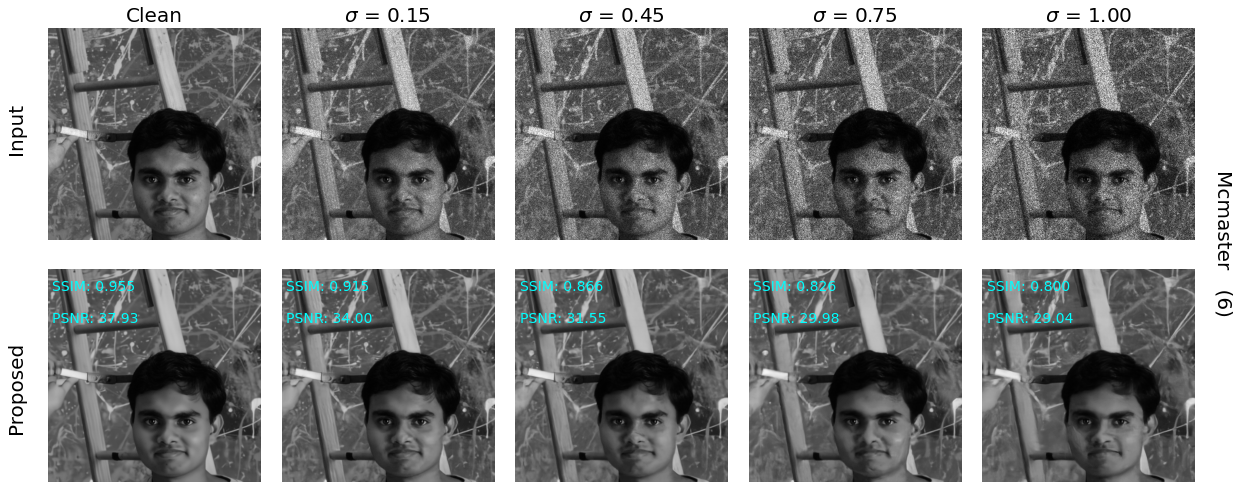

Saved layout to ../results/noise_level_Mcmaster   (6).pdf


/home/g202319350/.local/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


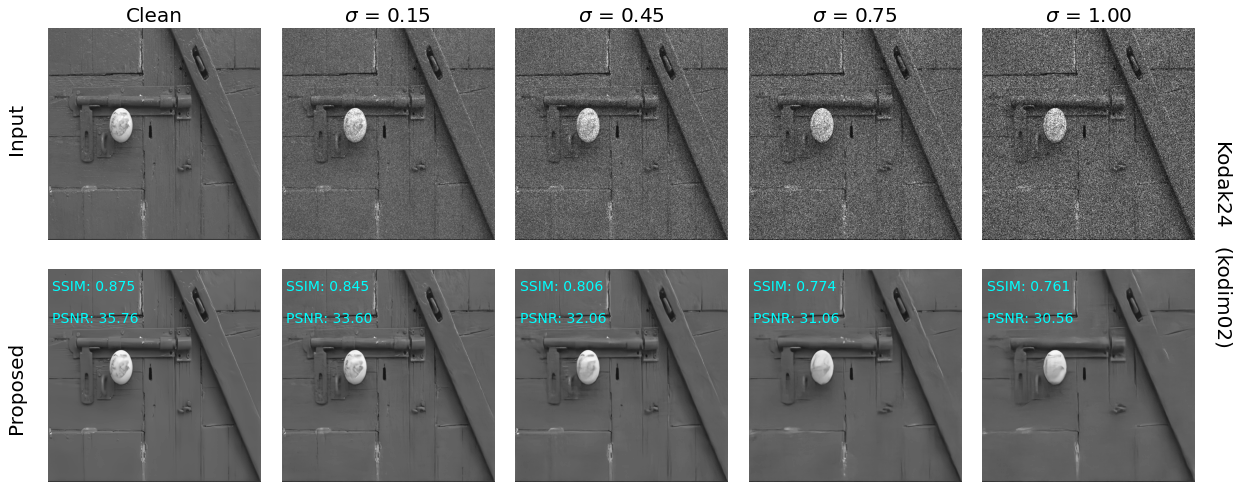

Saved layout to ../results/noise_level_Kodak24   (kodim02).pdf


/home/g202319350/.local/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


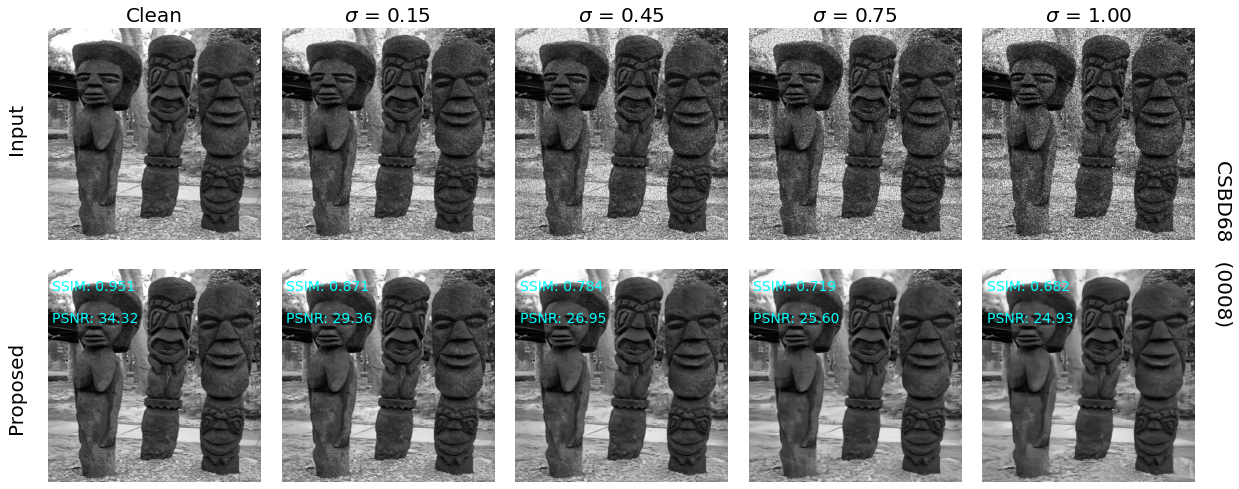

Saved layout to ../results/noise_level_CSBD68   (0008).pdf


/home/g202319350/.local/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


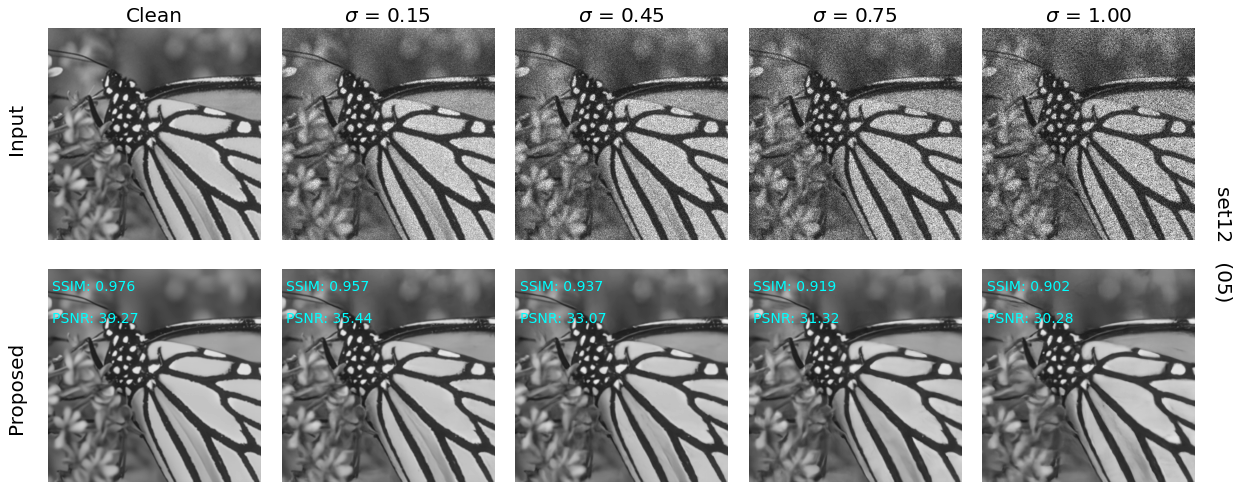

Saved layout to ../results/noise_level_set12   (05).pdf


/home/g202319350/.local/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


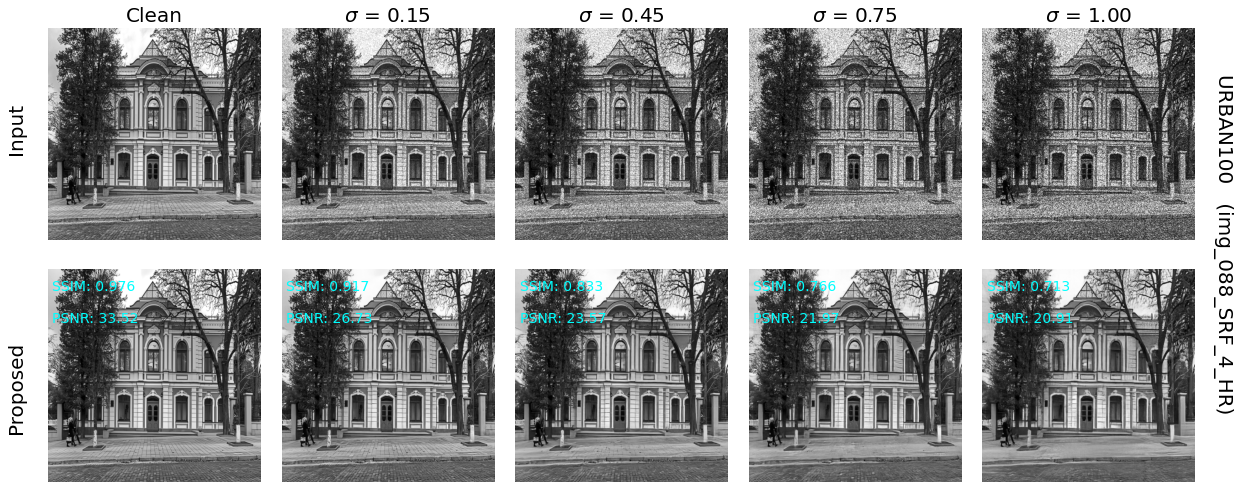

Saved layout to ../results/noise_level_URBAN100   (img_088_SRF_4_HR).pdf


/home/g202319350/.local/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


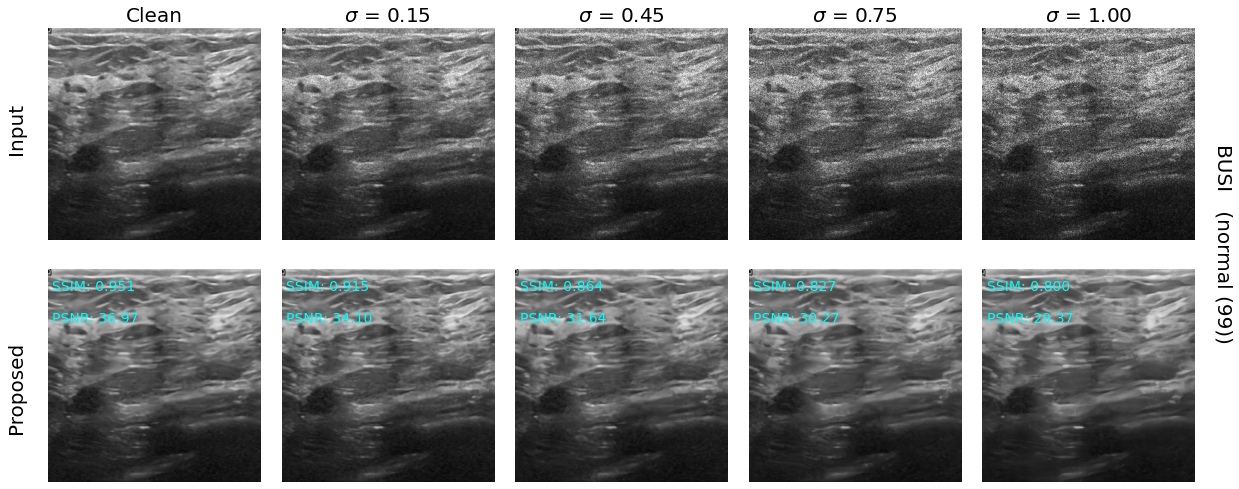

Saved layout to ../results/noise_level_BUSI   (normal (99)).pdf


In [8]:
def visualize_noise_blocks_layout(clean_image_paths, torch_models, save_path_prefix="noise_level"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    se_scunet_mini = torch_models[3]
    noise_levels = [0.00, 0.15, 0.45, 0.75, 1.00]
    num_levels = len(noise_levels)

    for idx, clean_path in enumerate(clean_image_paths):
        clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
        clean = cv2.resize(clean, (512, 512)).astype(np.float32) / 255.0

        # Generate noisy images including clean (σ=0.00)
        noisy_imgs = [add_speckle_noise(clean * 255, sigma=s).astype(np.float32) / 255.0 for s in noise_levels]
        torch_noisy_inputs = [torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device) for img in noisy_imgs]

        input_metrics = {}

        with torch.no_grad():
            denoised_mini = [se_scunet_mini(t).squeeze().cpu().numpy() for t in torch_noisy_inputs]

        fig = plt.figure(figsize=(num_levels * 3.5, 8))  # no +1 anymore
        gs = GridSpec(2, num_levels, figure=fig)

        # Dataset label on the right
        dataset_label = clean_path.split("/")[-3].split("-")[-1] + f"   ({ clean_path.split('/')[-1]})".replace('.png', '')
        fig.text(0.99, 0.5, dataset_label, fontsize=20, rotation=-90, va='center', ha='right')

        for i in range(num_levels):
            # Top row: noisy (or clean if sigma=0)
            ax_top = fig.add_subplot(gs[0, i])
            ax_top.imshow(noisy_imgs[i], cmap='gray', vmin=0, vmax=1)
            # ax_top.set_title(f"$\\sigma$ = {noise_levels[i]:.2f} {'(clean)' if noise_levels[i]==0 else ''}", fontsize=20)
            if np.isclose(noise_levels[i], 0.0):
                ax_top.set_title("Clean", fontsize=20)
            else:
                ax_top.set_title(f"$\\sigma$ = {noise_levels[i]:.2f}", fontsize=20)
            ax_top.axis('off')

            # Bottom row: denoised output
            ax_bot = fig.add_subplot(gs[1, i])
            ax_bot.imshow(denoised_mini[i], cmap='gray', vmin=0, vmax=1)
            ax_bot.axis('off')

            # Metrics
            psnr = peak_signal_noise_ratio(clean, denoised_mini[i], data_range=1.0)
            ssim = structural_similarity(clean, denoised_mini[i], data_range=1.0)
            ax_bot.text(0.02, 0.75, f"PSNR: {psnr:.2f}", fontsize=14, color='cyan', transform=ax_bot.transAxes)
            ax_bot.text(0.02, 0.90, f"SSIM: {ssim:.3f}", fontsize=14, color='cyan', transform=ax_bot.transAxes)

            # Input noise metrics
            sigma_str = f"{noise_levels[i]:.2f}"
            psnr_input = peak_signal_noise_ratio(clean, noisy_imgs[i], data_range=1.0)
            ssim_input = structural_similarity(clean, noisy_imgs[i], data_range=1.0)
            input_metrics[sigma_str] = {
                "PSNR": round(psnr_input, 4),
                "SSIM": round(ssim_input, 4)
            }

        # Left-side labels
        fig.text(0.025, 0.70, "Input", fontsize=20, ha='center', va='center', rotation=90)
        fig.text(0.025, 0.25, "Proposed", fontsize=20, ha='center', va='center', rotation=90)

        # Layout and save
        plt.subplots_adjust(left=0.05, right=0.96, top=0.90, bottom=0.06, wspace=0.10, hspace=0.00)
        os.makedirs("../results/", exist_ok=True)
        out_path = f"../results/{save_path_prefix}_{dataset_label}.pdf"
        out_path_png = out_path.replace('pdf', 'png')
        plt.savefig(out_path, dpi=600, bbox_inches='tight')
        plt.savefig(out_path_png, dpi=600, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Saved layout to {out_path}")


paths = [
     "../datasets/01-Mcmaster/original/6.png",

     "../datasets/02-Kodak24/original/kodim02.png",

     "../datasets/03-CSBD68/original/0008.png",

     "../datasets/04-set12/original/05.png",

     "../datasets/05-URBAN100/original/img_088_SRF_4_HR.png",

     "../datasets/06-BUSI/original/normal (99).png", 
]

visualize_noise_blocks_layout(paths, torch_models)

In [9]:
target_folders = [
    "01-Mcmaster",
    "02-Kodak24",
    "03-CSBD68",
    "04-set12",
    "05-URBAN100",
     "06-BUSI",
]

dataset_root = "../datasets"

def evaluate_model_on_folder(model, folder_path, sigma: float):
    psnr_scores = []
    ssim_scores = []

    for root, _, files in os.walk(folder_path):
        if "original" not in root:
            continue

        png_files = [f for f in files if f.endswith(".png")]

        for file in tqdm(png_files, desc=f"Processing in {os.path.basename(root)}"):
            if "URBAN100" in folder_path and "LR" in file:
                continue  # Skip low-resolution images from URBAN100

            path = os.path.join(root, file)
            img = Image.open(path).convert("L")
            img_np = np.array(img)

            noisy_np = add_speckle_noise(img_np, sigma=sigma)
            noisy_tensor = to_tensor(Image.fromarray(noisy_np)).unsqueeze(0).to(device)

            with torch.no_grad():
                output_tensor = model(noisy_tensor).clamp(0, 1)

            output_img = to_pil_image(output_tensor.squeeze(0).cpu())
            output_np = np.array(output_img.convert("L"))
            original_np = np.array(img)

            psnr = peak_signal_noise_ratio(original_np, output_np, data_range=255)
            ssim = structural_similarity(original_np, output_np, data_range=255)

            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

            del noisy_tensor, output_tensor
            torch.cuda.empty_cache()

    if psnr_scores:
        return sum(psnr_scores) / len(psnr_scores), sum(ssim_scores) / len(ssim_scores)
    else:
        return 0, 0

# Evaluation loop
for model, name in zip(torch_models, ["UNet", "SCUNet", "SE-SCUNet", "SE-SCUNet-mini"]):
    print(f"\nEvaluating model: {name}")
    model.to(device)
    model.eval()

    all_psnr = []
    all_ssim = []

    for folder in target_folders:
        folder_path = os.path.join(dataset_root, folder)
        psnr, ssim = evaluate_model_on_folder(model, folder_path, sigma=0.15)
        print(f"  {folder}: PSNR={psnr:.2f}, SSIM={ssim:.4f}")
        all_psnr.append(psnr)
        all_ssim.append(ssim)

    print(f"Average for {name} → PSNR={np.mean(all_psnr):.2f}, SSIM={np.mean(all_ssim):.4f}")

    model.cpu()
    torch.cuda.empty_cache()



Evaluating model: UNet


Processing in original: 100%|██████████| 18/18 [00:01<00:00, 15.87it/s]


  01-Mcmaster: PSNR=29.82, SSIM=0.8608


Processing in original: 100%|██████████| 24/24 [00:02<00:00, 10.76it/s]


  02-Kodak24: PSNR=30.59, SSIM=0.8660


Processing in original: 100%|██████████| 68/68 [00:02<00:00, 24.41it/s]


  03-CSBD68: PSNR=28.09, SSIM=0.8257


Processing in original: 100%|██████████| 12/12 [00:00<00:00, 26.55it/s]


  04-set12: PSNR=30.66, SSIM=0.8715


Processing in original: 100%|██████████| 200/200 [00:20<00:00,  9.92it/s]


  05-URBAN100: PSNR=29.82, SSIM=0.9003


Processing in original: 100%|██████████| 780/780 [00:58<00:00, 13.42it/s]


  06-BUSI: PSNR=27.11, SSIM=0.7990
Average for UNet → PSNR=29.35, SSIM=0.8539

Evaluating model: SCUNet


Processing in original: 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]


  01-Mcmaster: PSNR=31.23, SSIM=0.8707


Processing in original: 100%|██████████| 24/24 [00:05<00:00,  4.53it/s]


  02-Kodak24: PSNR=31.24, SSIM=0.8720


Processing in original: 100%|██████████| 68/68 [00:06<00:00, 10.51it/s]


  03-CSBD68: PSNR=29.28, SSIM=0.8488


Processing in original: 100%|██████████| 12/12 [00:01<00:00, 11.48it/s]


  04-set12: PSNR=30.77, SSIM=0.8746


Processing in original: 100%|██████████| 200/200 [00:42<00:00,  4.70it/s]


  05-URBAN100: PSNR=30.70, SSIM=0.9095


Processing in original: 100%|██████████| 780/780 [02:18<00:00,  5.63it/s]


  06-BUSI: PSNR=32.82, SSIM=0.8893
Average for SCUNet → PSNR=31.01, SSIM=0.8775

Evaluating model: SE-SCUNet


Processing in original: 100%|██████████| 18/18 [00:02<00:00,  7.38it/s]


  01-Mcmaster: PSNR=33.08, SSIM=0.9176


Processing in original: 100%|██████████| 24/24 [00:05<00:00,  4.46it/s]


  02-Kodak24: PSNR=31.66, SSIM=0.8779


Processing in original: 100%|██████████| 68/68 [00:06<00:00, 10.11it/s]


  03-CSBD68: PSNR=30.08, SSIM=0.8735


Processing in original: 100%|██████████| 12/12 [00:01<00:00, 11.56it/s]


  04-set12: PSNR=31.16, SSIM=0.8809


Processing in original: 100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


  05-URBAN100: PSNR=31.58, SSIM=0.9251


Processing in original: 100%|██████████| 780/780 [02:20<00:00,  5.55it/s]


  06-BUSI: PSNR=33.91, SSIM=0.9054
Average for SE-SCUNet → PSNR=31.91, SSIM=0.8967

Evaluating model: SE-SCUNet-mini


Processing in original: 100%|██████████| 18/18 [00:01<00:00, 12.23it/s]


  01-Mcmaster: PSNR=32.85, SSIM=0.9140


Processing in original: 100%|██████████| 24/24 [00:03<00:00,  6.97it/s]


  02-Kodak24: PSNR=31.54, SSIM=0.8773


Processing in original: 100%|██████████| 68/68 [00:04<00:00, 15.64it/s]


  03-CSBD68: PSNR=29.77, SSIM=0.8650


Processing in original: 100%|██████████| 12/12 [00:00<00:00, 18.13it/s]


  04-set12: PSNR=31.01, SSIM=0.8802


Processing in original: 100%|██████████| 200/200 [00:27<00:00,  7.18it/s]


  05-URBAN100: PSNR=31.14, SSIM=0.9211


Processing in original: 100%|██████████| 780/780 [01:26<00:00,  9.06it/s]

  06-BUSI: PSNR=33.84, SSIM=0.9053
Average for SE-SCUNet-mini → PSNR=31.69, SSIM=0.8938
